# Predicting Diabetes in Adults
### Ian Klasky
#### Aug 19, 2020

Diabetes is a costly diseases to both the patient, as well as our healthcare system. Cheaper and easier methods for detecting diabetes could help identify the disease earlier to improve health outcomes as well as decrease strain on our medical systems.

In this notebook we will use data from the National Health and Nutrition Examination Survey (NHANES) along with machine learning algorithms to predict the occurence of diabetes in adults in the United States.

The notebook is structured as follows:

* [Preprocessing](#Preprocessing)
    * [Importing Basic Packages & Data](#Importing)
    * [Feature Engineering](#Feature)
        * [Dropping Variables](#fc1)
        * [Imputation](#fc1)
        * [Creating Dummy Variables](#fc1)
* [Modeling](#Modeling)
    * [Logistic Regression](#Logistic)
    * [Random Forest](#Random)
* [Conclusions](#Conclusions)

# Preprocessing<a name="Preprocessing"></a>

## Importing Basic Packages & Data<a name="Importing"></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

The CDC publishes data from it's longitudinal NHANES study on it's [website](https://wwwn.cdc.gov/Nchs/Nhanes/).

For this project I used the data collected from the years 2013-2014, as the CDC created a Kaggle post and community discussion about the data from these years. This dataset can be found [here](https://wwwn.cdc.gov/Nchs/Nhanes/continuousnhanes/default.aspx?BeginYear=2013).

Of the 2013-2014 data, I only used the demographic, and questionaire information to predict patients having diabetes. I did not use other available csv's from this data set that contined the results of various medical tests and procedures, in an effort to ultimately base my predictions on readily accesible patient data, without requiring expensive tests.

In [2]:
df1 = pd.read_csv('data/demographic.csv')
df2 = pd.read_csv('data/questionnaire.csv')

df = pd.concat([df1, df2], axis=1, join='inner')

df.head()

,SEQN,SDDSRVYR,RIDSTATR,RIAGENDR,RIDAGEYR,RIDAGEMN,RIDRETH1,RIDRETH3,RIDEXMON,RIDEXAGM,...,WHD080U,WHD080L,WHD110,WHD120,WHD130,WHD140,WHQ150,WHQ030M,WHQ500,WHQ520
0,73557,8,2,1,69,NaN,4,4,1.0,NaN,...,NaN,40.0,270.0,200.0,69.0,270.0,62.0,NaN,NaN,NaN
1,73558,8,2,1,54,NaN,3,3,1.0,NaN,...,NaN,NaN,240.0,250.0,72.0,250.0,25.0,NaN,NaN,NaN
2,73559,8,2,1,72,NaN,3,3,2.0,NaN,...,NaN,NaN,180.0,190.0,70.0,228.0,35.0,NaN,NaN,NaN
3,73560,8,2,1,9,NaN,3,3,1.0,119.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3.0,3.0
4,73561,8,2,2,73,NaN,3,3,1.0,NaN,...,NaN,NaN,150.0,135.0,67.0,170.0,60.0,NaN,NaN,NaN


In the cells below we see the increased number of nearly complete columns when we drop the participants that are younger than 18 years old from the dataset.

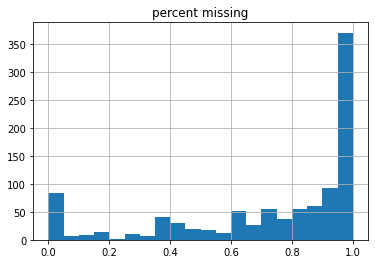

In [3]:
nas=pd.DataFrame(df.isnull().sum().sort_values(ascending=False)/len(df),columns = ['percent missing'])
pos = nas['percent missing'] > 0
nas[pos]
nas.hist(bins = 20)
acceptable_feats = nas.loc[nas['percent missing'] < 0.2]
list_acceptable_feats = list(acceptable_feats.index)

In [4]:
print('Shape of DataFrame with all data: ', df.shape)
df = df.loc[(df.RIDAGEYR >= 18)]
df2 = df1#[df1.columns[df1.isna().sum() < 1000]]
print('Shape of DataFrame with only 20 year olds and older: ', df.shape)

Shape of DataFrame with all data:  (10175, 1000)
Shape of DataFrame with only 20 year olds and older:  (6113, 1000)


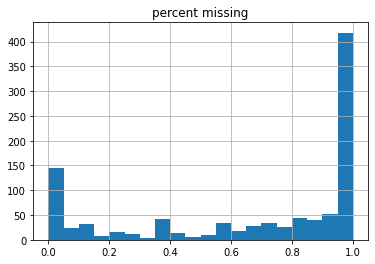

In [5]:
nas=pd.DataFrame(df.isnull().sum().sort_values(ascending=False)/len(df),columns = ['percent missing'])
pos = nas['percent missing'] > 0
nas[pos]
nas.hist(bins = 20)
acceptable_feats = nas.loc[nas['percent missing'] < 0.2]
list_acceptable_feats = list(acceptable_feats.index)

In [6]:
c = df[list_acceptable_feats].corr().abs()
dc = c['DIQ010'].dropna().sort_values(kind="quicksort", ascending=False)

#with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
print(dc)

DIQ010      1.000000
DIQ160      0.363480
DIQ050      0.342668
RIDAGEYR    0.177234
MCQ365D     0.176189
              ...   
DMDBORN4    0.001508
FSDHH       0.001427
MCQ160K     0.001338
FSD032A     0.000870
CBQ535      0.000343
Name: DIQ010, Length: 203, dtype: float64


In [7]:
df = df[list_acceptable_feats]
df = df[df['DIQ010'].notna()]
df = df[df['DIQ010'] != 3]
df = df[df['DIQ010'] != 7]
df = df[df['DIQ010'] != 9]
ROO = df[df['DIQ010'] == 1].shape[0]/df.shape[0]
df['DIQ010'] = df['DIQ010'].replace({2:0})
print("Percentage of survey responders with diabetes: ", ROO)

Percentage of survey responders with diabetes:  0.12234580384226491


Below is the distribution of adult patients that have (1) and don't have (0) diabetes.

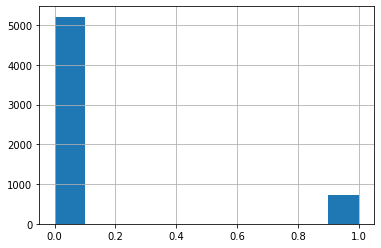

In [8]:
df['DIQ010'].hist()

In [9]:
from sklearn.impute import KNNImputer
import time

tic = time.time()

col_names = list(df.columns)

print('Before imputation: ', df.isnull().sum().sum(), 'missing')

#fill na's with medians
for col in df.columns:
    df[col] = df[col].fillna((df[col].median()))
    
#fill na's using KNN
#imputer = KNNImputer(n_neighbors=3)
#df = pd.DataFrame(imputer.fit_transform(df))
      
print('After imputation: ', df.isnull().sum().sum(), 'missing')

df.columns = col_names

toc = time.time()
print('runtime: ',toc-tic)

Before imputation:  42126 missing
After imputation:  0 missing
runtime:  0.517287015914917


In [10]:
print('Shape of DataFrame before dropping unwanted features: ', df.shape)
remove_list = ['DIQ160', 'DIQ050', 'DIQ180', 'DIQ172', 'DIQ170']#, 'SLQ060', 'SIAPROXY', 'HUQ010', 'HUQ010', 'DMDHRAGE', 'DLQ060', 'RIDAGEYR', 'DLQ050', 'WTINT2YR', 'WTMEC2YR']
keep_list = set(df.columns) - set(remove_list)
df = df[keep_list]
prefix_list = []#['MCQ','HUQ','BPQ','PFQ','DLQ','HSD', 'OHQ', 'WHQ', 'SEQN', 'DPQ', 'HIQ', 'HSQ', 'WHD', 'DMD', 'DBQ']
df = df.loc[:,~df.columns.str.startswith(tuple(prefix_list))]
print('Shape of DataFrame after dropping unwanted features: ', df.shape)

# c1 = df.corr().abs()
# dc1 = c1['DIQ010'].dropna().sort_values(kind="quicksort", ascending=False)

# df = df[list(dc1.index)[:8]]

# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#     print(dc1[:8])

Shape of DataFrame before dropping unwanted features:  (5934, 209)
Shape of DataFrame after dropping unwanted features:  (5934, 204)


We will now select feature using logistic regression.

In [11]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

X_fs = df.drop('DIQ010',axis=1)
y_fs = df['DIQ010']

model = LogisticRegression()
rfe = RFE(model, 63)
fit = rfe.fit(X_fs, y_fs)
print("Num Features: %s" % (fit.n_features_))
print("Selected Features: %s" % (fit.support_))
print("Feature Ranking: %s" % (fit.ranking_))

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass n_features_to_select=63 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: l

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

Num Features: 63
Selected Features: [False  True  True False  True False  True False False  True  True False
 False False False False False False False  True  True False False False
 False  True False False False  True  True False False False False False
 False  True False  True False False  True False False  True False False
 False False False False False False  True False False  True False  True
 False False  True False False False  True  True False  True  True  True
 False False False  True  True False False False  True False  True  True
  True False False  True  True False False False False False False False
 False False  True  True  True False False False False  True  True False
 False  True False False False  True  True False False  True False False
  True False False  True False False False False False False False  True
  True False False False False False  True False False False False  True
 False  True False False False  True False  True False False  True False
 False False Fa

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [12]:
#print(type(list(fit.support_)))
#print(type(list(X_fs.columns)))
fs_results = zip(list(fit.support_),list(X_fs.columns))

selected_feats = []
for TF, col_name in fs_results:
    if TF == True:
        selected_feats.append(col_name)
print(selected_feats)

['PFQ054', 'HUQ071', 'DPQ010', 'DPQ040', 'MCQ365B', 'HUQ051', 'DMDHREDU', 'MCQ370A', 'OHQ033', 'HSD010', 'HUQ010', 'PFQ057', 'BPQ080', 'PAQ635', 'PAQ715', 'DBQ700', 'MCQ365C', 'DMDHHSIZ', 'RIDRETH3', 'DMDEDUC2', 'BPQ059', 'SLD010H', 'MCQ365D', 'INQ080', 'BPQ056', 'SLQ060', 'INQ030', 'DMDFMSIZ', 'DLQ010', 'DLQ050', 'INQ020', 'MCQ300C', 'PAQ710', 'HUQ020', 'HOQ065', 'OCD150', 'OCD390G', 'RIDAGEYR', 'MCQ365A', 'HSQ590', 'MCQ160E', 'DPQ030', 'MCQ370D', 'BPQ020', 'DPQ080', 'DMDMARTL', 'SLQ050', 'PFQ090', 'WHQ040', 'PAQ650', 'PFQ049', 'DMDHHSZE', 'SMQ878', 'MCQ370C', 'DLQ020', 'MCQ160A', 'MCQ080', 'DMDHHSZA', 'DPQ050', 'DPQ060', 'HUQ030', 'DPQ070', 'HIQ011']


In [13]:
from sklearn import preprocessing

#df['DIQ010'] = df['DIQ010'].replace({2:0})

#X = df.drop('DIQ010',axis=1)
X = df[selected_feats]
y = df['DIQ010']

#Dummy variables
dummy_list = []
# for col in df.drop('DIQ010', 1).columns:
#     print(df[col].max())
#     if df[col].max() <= 99 and df[col].max() != 80:
#         dummy_list.append(col)
# X = pd.get_dummies(X, prefix=dummy_list, columns=dummy_list)

for col in X.columns:
    if X[col].max() <= 99 and X[col].max() != 80:
        dummy_list.append(col)
X = pd.get_dummies(X, prefix=dummy_list, columns=dummy_list)

# Here we use the StandardScaler() method of the preprocessing package, and then call the fit() method with parameter X 
scaler = preprocessing.StandardScaler().fit(X)

# Declare a variable called X_scaled, and assign it the result of calling the transform() method with parameter X 
X_scaled=scaler.transform(X)

# Get the 1-dimensional flattened array of our response variable y by calling the ravel() function on y
y = y.ravel()

In [14]:
from sklearn.model_selection import train_test_split

# Call the train_test_split() function with the first two parameters set to X_scaled and y 
# Declare four variables, X_train, X_test, y_train and y_test separated by commas 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

We will now run a logistic regression model on our remaining features to predict for diabetes.

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [16]:
y_pred_lr = logreg.predict(X_test)

In [17]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
fpr, tpr, threshold = metrics.roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
roc_auc = metrics.auc(fpr, tpr)

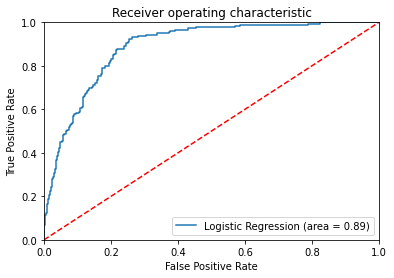

In [18]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
logit_roc_auc = roc_auc_score(y_test, logreg.predict_proba(X_test)[:,1])
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [19]:
roc_auc_score(y_test, logreg.predict_proba(X_test)[:,1])

0.8889696646420153

In [20]:
from sklearn.metrics import classification_report, confusion_matrix
conf_mat_lr = pd.DataFrame(confusion_matrix(y_test, y_pred_lr),columns=['pred_neg', 'pred_pos'], index=['neg', 'pos'])
print('\nConfusion matrix of Logistic Regression model\n')
print(conf_mat_lr)
print('\nSensitivity: ', round(conf_mat_lr.pred_pos[1]/(conf_mat_lr.pred_neg[1]+conf_mat_lr.pred_pos[1]),4))
print('Sensitivity / rate of occurence in sample: ', round(conf_mat_lr.pred_pos[1]/(conf_mat_lr.pred_neg[1]+conf_mat_lr.pred_pos[1])/ROO,4))
print('Specificity: ', round(conf_mat_lr.pred_neg[0]/(conf_mat_lr.pred_neg[0]+conf_mat_lr.pred_pos[0]),4))


Confusion matrix of Logistic Regression model

     pred_neg  pred_pos
neg      1263        43
pos       121        57

Sensitivity:  0.3202
Sensitivity / rate of occurence in sample:  2.6174
Specificity:  0.9671


In [21]:
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_jobs=-1)

param_grid = {
    'n_estimators' : [150,175,200],
    'max_depth': [15,25,50],
    'max_features': [16,18,19]
}

scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score),
    'roc_auc_score': make_scorer(roc_auc_score)
}

In [22]:
def grid_search_wrapper(refit_score='roc_auc_score'):
    """
    fits a GridSearchCV classifier using refit_score for optimization
    prints classifier performance metrics
    """
    grid_search = GridSearchCV(clf, param_grid, scoring=scorers, refit=refit_score,
                           cv=5, return_train_score=True, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # make the predictions
    y_pred = grid_search.predict(X_test.values)

    print('Best params for {}'.format(refit_score))
    print(grid_search.best_params_)

    # confusion matrix on the test data.
    print('\nConfusion matrix of Random Forest optimized for {} on the test data:'.format(refit_score))
    conf_mat = pd.DataFrame(confusion_matrix(y_test, y_pred),columns=['pred_neg', 'pred_pos'], index=['neg', 'pos'])
    print(conf_mat)
    print('\nSensitivity: ', round(conf_mat.pred_pos[1]/(conf_mat.pred_neg[1]+conf_mat.pred_pos[1]),4))
    print('Sensitivity / rate of occurence in sample: ', round((conf_mat.pred_pos[1]/(conf_mat.pred_neg[1]+conf_mat.pred_pos[1]))/ROO,4))
    print('\nSpecificity: ', round(conf_mat.pred_neg[0]/(conf_mat.pred_neg[0]+conf_mat.pred_pos[0]),4))
    return grid_search

In [23]:
grid_search_clf = grid_search_wrapper(refit_score='roc_auc_score')

Best params for roc_auc_score
{'max_depth': 50, 'max_features': 16, 'n_estimators': 175}

Confusion matrix of Random Forest optimized for roc_auc_score on the test data:
     pred_neg  pred_pos
neg      1292        14
pos       152        26

Sensitivity:  0.1461
Sensitivity / rate of occurence in sample:  1.1939

Specificity:  0.9893
